In [1]:
#code is used from these 3 repositories, have a look at them on GitHub or access the files from colab
!git clone https://github.com/PeterWang512/FALdetector
!git clone https://github.com/NVIDIA/flownet2-pytorch.git
!git clone https://github.com/Kwanss/PCLNet

Cloning into 'FALdetector'...
remote: Enumerating objects: 116, done.
remote: Total 116 (delta 0), reused 0 (delta 0), pack-reused 116
Receiving objects: 100% (116/116), 21.21 MiB | 32.85 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Cloning into 'flownet2-pytorch'...
remote: Enumerating objects: 557, done.
remote: Total 557 (delta 0), reused 0 (delta 0), pack-reused 557
Receiving objects: 100% (557/557), 6.28 MiB | 24.64 MiB/s, done.
Resolving deltas: 100% (312/312), done.
Cloning into 'PCLNet'...
remote: Enumerating objects: 51, done.
remote: Total 51 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (51/51), done.


In [2]:

#import necessary modules and append paths 
import random
import os
import csv
import pickle
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import sys
sys.path.append("/content/FALdetector/networks/")
sys.path.append("/content/FALdetector/")
from drn_seg import DRNSeg
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss,BCELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
sys.path.append("/content/flownet2-pytorch/")
import losses
from losses import MultiScale,EPE
sys.path.append("/content/PCLNet/Losses/")
sys.path.append("/content/PCLNet/models/")
from utils.tools import *
from utils.visualize import *
import pandas as pd
import numpy as np
import torch.nn as nn
# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data, color
from torchsummary import summary
from skimage.util import random_noise
from skimage.transform import rotate

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive
!unzip /mydrive/nofakes/flow_pred_data/modified.zip -d modif
!unzip /mydrive/nofakes/flow_pred_data/reference.zip -d ref
!unzip /mydrive/nofakes/flow_pred_data/local_weight.zip -d weights

Mounted at /content/gdrive
Archive:  /mydrive/nofakes/flow_pred_data/modified.zip
  inflating: modif/ref_001.jpg       
  inflating: modif/ref_002.jpg       
  inflating: modif/ref_003.jpg       
  inflating: modif/ref_004.jpg       
  inflating: modif/ref_005.jpg       
  inflating: modif/ref_006.jpg       
Archive:  /mydrive/nofakes/flow_pred_data/reference.zip
  inflating: ref/ref_001.jpg         
  inflating: ref/ref_002.jpg         
  inflating: ref/ref_003.jpg         
  inflating: ref/ref_004.jpg         
  inflating: ref/ref_005.jpg         
  inflating: ref/ref_006.jpg         
Archive:  /mydrive/nofakes/flow_pred_data/local_weight.zip
  inflating: weights/local.pth       


In [4]:
pathM =r"/content/modif"
path =r"/content/ref"
import random
#if you guys can come up with a more efficient way to do this go ahead.
height, width = 400, 400
#variable to control how many training examples to import
train_size = 3
batch_size = train_size
filenames = []
   
#Redo this part.... it doesnt import training images in order, I have printed out the filenames imported for convenience
# 23/01/21 added augmentation, convert PNG to JPG, and read files in order 



def createTrain(path, n_images):
    
    arr=[]
    count = 0
    for root, dirs, files in os.walk(path, topdown=True):
        
        for name in files:
          #make sure to change to correct image format .jpg or .png etc...
            #print(count)
            if '.png' in name:
                #print(name)
                img = Image.open(r"" + path + "/" + str(name))
                img.save(r"" + path + "/" + str(name) + ".jpg")
                
            if '.jpg' in name:
                
                #print(name)
                img = Image.open(r"" + path + "/" + str(name))
                filenames.append(path + "/" + str(name))
                
                #keep image dimensions at 400 for now, the following is image interpolation
                img_height, img_width = img.size
               
                    
                #for the case where we don't shrink   
                img = img.resize( (width, height))
                arr.append(np.array(img))
            count+=1
            if count>=train_size:
              break
    return np.array(arr,dtype =np.uint8)            

X_ref=createTrain(path,train_size)
X_mod = createTrain(pathM,train_size)

print("the filenames are",filenames)
shape = X_ref.shape
print(shape)

the filenames are ['/content/ref/ref_003.jpg', '/content/ref/ref_002.jpg', '/content/ref/ref_001.jpg', '/content/modif/ref_003.jpg', '/content/modif/ref_002.jpg', '/content/modif/ref_001.jpg']
(3, 400, 400, 3)


[[[184 187 192]
  [184 187 192]
  [184 187 192]
  ...
  [186 194 197]
  [186 194 197]
  [186 194 197]]

 [[185 188 193]
  [185 188 193]
  [185 188 193]
  ...
  [186 194 197]
  [186 194 197]
  [186 194 197]]

 [[185 188 193]
  [185 188 193]
  [185 188 193]
  ...
  [186 194 197]
  [186 194 197]
  [186 194 197]]

 ...

 [[221 221 221]
  [221 221 221]
  [221 221 221]
  ...
  [181 183 181]
  [180 183 180]
  [180 182 180]]

 [[221 221 221]
  [221 221 221]
  [221 221 221]
  ...
  [195 197 193]
  [194 196 192]
  [194 196 192]]

 [[221 221 221]
  [221 221 221]
  [221 221 221]
  ...
  [200 202 197]
  [200 202 197]
  [199 201 196]]]


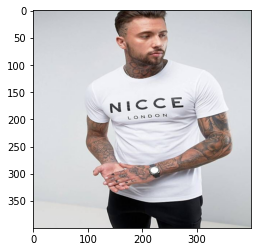

In [5]:
plt.imshow(X_ref[0])
print(X_ref[0])

In [6]:
flow_arr =[]
#calcOptical gives an error if I input all training data at once (doesnt seem very efficient atm)
for i in range(shape[0]):
    flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(X_ref[i],cv2.COLOR_BGR2GRAY), cv2.cvtColor(X_mod[i],cv2.COLOR_BGR2GRAY), None, 0.5, 3, 15, 3, 5, 1.2, 0)
    print(flow.shape)
    print(np.max(flow))
    flow_arr.append(flow)    
print(X_mod.shape)

flow_arr = np.array(flow_arr)

mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
print(mag)
print(mag.shape)
path = "tester_before_train.png"
tester = save_heatmap_cv(X_mod[0], mag, path)
#print(flow)
print("flow arr has shape",flow_arr.shape)
#the code below is pretty similar to how the binary classifier is trained with a few changes 
#since the output shape is (2,height,width) for the vector field

(400, 400, 2)
21.19631
(400, 400, 2)
8.537996
(400, 400, 2)
88.98829
(3, 400, 400, 3)
[[8.1765558e-07 1.2523710e-06 1.8209322e-06 ... 1.3965121e-05
  1.4102451e-05 1.2505332e-05]
 [2.6523976e-06 3.0893380e-06 3.8772291e-06 ... 1.4489184e-05
  1.4417322e-05 1.2681738e-05]
 [1.1175695e-05 2.0860942e-05 3.2308308e-05 ... 1.6468750e-05
  1.5953678e-05 1.3825039e-05]
 ...
 [4.8568065e-05 3.4312590e-05 2.0032954e-05 ... 1.2634443e-02
  1.2573209e-02 8.0045318e-04]
 [3.0599971e-05 2.5870018e-05 2.5357771e-05 ... 3.6808036e-02
  1.6867274e-02 5.6606741e-04]
 [1.4253483e-05 1.3097054e-05 1.2590008e-05 ... 1.3673598e-01
  3.5667952e-02 3.9928436e-04]]
(400, 400)
flow arr has shape (3, 400, 400, 2)


**Discretize the flow fields**

In [7]:
categorical_flow =[]
dic ={}
inv_dic={}
counter =0
#create a placeholder for the (u,v)->class pairs, hashmap is the easiest as its O(1) lookup time for the values
#Note when obtaining flow values from classes it takes O(n) time to look up each one, not very efficient so
#maybe re-do this part so that the hashmap key-value pairs are {class_pairs:(u,v)}

#max and minimum allowed flow values
max_f =5
min_f=-5
#fill up hashmap with values
for i in range(min_f,max_f+1):
  for j in range(min_f,max_f+1):
    dic[i,j]=counter
    inv_dic[counter]=[i,j]
    counter+=1
dimens= flow_arr.shape

#categorise the flow into distinct values
print("CATEGORISING FLOW...")
for flows in flow_arr:
  temp_flow =np.zeros((dimens[1],dimens[2]))
  for i in range(dimens[1]):
    for j in range(dimens[2]):
      value = flows[i][j]
      #makes sure we are not going over the max and min values 
      if (value[1]>max_f or value[1]<min_f or value[0]>max_f or value[0]<min_f):
        continue
      temp_flow[i][j]=dic[int(value[0]),int(value[1])]     
  categorical_flow.append(temp_flow)
#convert into numpy array
categorical_flow = np.array(categorical_flow)

CATEGORISING FLOW...


In [8]:
#Sanity check to make sure shapes add up

#print(categorical_flow.shape)
#print(categorical_flow[0][100])

In [9]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [10]:
#check if GPU is available
cuda0 = torch.device('cuda:0')

if torch.cuda.is_available():
    device = 'cuda:{}'.format("0")
else:
    device = 'cpu'

In [11]:
temp = torch.randn(1, 3, 200, 200)
temp = temp.cuda()

#just add a tanh activation onto it
perPix_model = DRNSeg(len(dic)).to(device)
summary(perPix_model, (3, height, width))
!ls /content/weights/local_weight
#perPix_model.load_pretrained(r"/content/weights/local_weight/local.pth")
perPix_model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]           2,352
       BatchNorm2d-2         [-1, 16, 400, 400]              32
              ReLU-3         [-1, 16, 400, 400]               0
            Conv2d-4         [-1, 16, 400, 400]           2,304
       BatchNorm2d-5         [-1, 16, 400, 400]              32
              ReLU-6         [-1, 16, 400, 400]               0
            Conv2d-7         [-1, 16, 400, 400]           2,304
       BatchNorm2d-8         [-1, 16, 400, 400]              32
              ReLU-9         [-1, 16, 400, 400]               0
       BasicBlock-10         [-1, 16, 400, 400]               0
           Conv2d-11         [-1, 32, 200, 200]           4,608
      BatchNorm2d-12         [-1, 32, 200, 200]              64
             ReLU-13         [-1, 32, 200, 200]               0
           Conv2d-14         [-1, 32, 2

DRNSeg(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(3

**Training the Classifier**

In [12]:
#changed crossentropy to MSE since cross entropy needs classes, we arent doing classification
#other losses might work much better 
from torch.utils.data import TensorDataset, DataLoader
optimizer = Adam(perPix_model.parameters(),lr=0.07) 
criterion =torch.nn.MSELoss()
criterion_classif = nn.CrossEntropyLoss()

import torchvision.transforms as transforms
tf = transforms.Compose([transforms.ToTensor()])

shape = X_mod.shape

#criterion = MultiScale(model)
if torch.cuda.is_available():
 
  perPix_model =perPix_model.cuda()
  criterion = criterion.cuda()
  criterion_classif=criterion_classif.cuda()
#convert to torch format
train_x = X_mod
print("train_x has shape",train_x.shape)
train_x_orig=X_ref

train_x = train_x.transpose(0,3,1,2)
train_x_orig = train_x_orig.transpose(0,3,1,2)
print("new train_x shape ius ",train_x.shape)

train_x  = torch.from_numpy(train_x)

#train_x_orig  = torch.from_numpy(train_x_orig).float()


# converting the target into torch format
train_y=flow_arr
cat_shape = categorical_flow.shape
print("categorical shape is",cat_shape)
categorical_label=torch.from_numpy(categorical_flow)
train_y = train_y.transpose(0,3,1,2)
print("train_y has shape: ",train_y.shape)
train_y = torch.from_numpy(train_y).float()
print("xtrain shape",train_x.shape)
print("y shape",categorical_label.shape)


#MAIN CHANGE, dataloader so that batches can be trained, use batch size of 1 and then multiple pictures can be trained
import math

batch_loader_size = 3



my_dataset_categ = TensorDataset(train_x, categorical_label) # create your datset
b_size = batch_loader_size
my_dataloader_cat = DataLoader(my_dataset_categ,batch_size=b_size)

#here is the batch version of the classification training function. Might be nice to add a counter to keep track of the epochs
def batch_train_classif(epoch):
    correct =0
    #epoch = 0
    #iterate over batches
    for idx,(x_t,y_t) in enumerate(my_dataloader_cat):
      #epoch += 1
      perPix_model.train()
      tr_loss = 0
      if epoch%10 == 0:
        print("Batch n° : " + str(idx))
        print("No of examples in batch : " + str(x_t.shape[0]))
      
      # getting the training set
      x_train, y_categorical = Variable(x_t), Variable(y_t)
      
      # converting the data into GPU format
      if torch.cuda.is_available():
          x_train = x_train.cuda()
          y_categorical = y_categorical.cuda()
      optimizer.zero_grad()
      
      # prediction for training and validation set
      output_train = perPix_model(x_train.float())
      
      #print("y has shape",y_categorical.shape)
      label_output = torch.argmax(output_train,dim=1)
      Loss = criterion_classif(output_train, y_categorical.long())
      #print(label_output)
      #print("label output has shape",label_output.shape)
      correct = (label_output==y_categorical).sum().float()/(height*width*b_size)
      total = train_size
      #print(Loss)
      train_losses.append(Loss)
        # computing the updated weights of all the model parameters
      Loss.backward()
      optimizer.step()
      tr_loss = Loss.item()
      if epoch%10 == 0:
          # printing the validation loss
          print('Epoch : ',epoch+1, "for Batch:",idx, '\t', 'loss :',Loss.item(),"accuracy: ",correct.item())
    



train_x has shape (3, 400, 400, 3)
new train_x shape ius  (3, 3, 400, 400)
categorical shape is (3, 400, 400)
train_y has shape:  (3, 2, 400, 400)
xtrain shape torch.Size([3, 3, 400, 400])
y shape torch.Size([3, 400, 400])


In [13]:
#Check for existing checkpoint in content/, train additional epochs if found
n_epochs_to_train = 100
train_losses =[]
correct =0

#same parameters the FAL paper have used
optimizer = Adam(perPix_model.parameters(),lr=0.0001,betas =(0.9,0.999))

checkpoint_path = r"checkpoint.pt"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    perPix_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    checkpoint_epoch = checkpoint['checkpoint_epoch']
    train_losses = checkpoint['train_losses']
    print("checkpoint loaded")
    print("checkpoint epoch:" + str(checkpoint_epoch))
else:
  checkpoint_epoch=0
  print("No existing checkpoint found")


for i in range(n_epochs_to_train):
  batch_train_classif(i)

print("In this run, another "+str(n_epochs_to_train)+" epochs were trained")
print("Total epochs model has been trained upon:" + str(checkpoint_epoch+n_epochs_to_train))




No existing checkpoint found
Batch n° : 0
No of examples in batch : 3
Epoch :  1 for Batch: 0 	 loss : 7.232855319976807 accuracy:  0.0009437500266358256
Batch n° : 0
No of examples in batch : 3
Epoch :  11 for Batch: 0 	 loss : 0.8710598945617676 accuracy:  0.9098020792007446
Batch n° : 0
No of examples in batch : 3
Epoch :  21 for Batch: 0 	 loss : 0.30422431230545044 accuracy:  0.9487312436103821
Batch n° : 0
No of examples in batch : 3
Epoch :  31 for Batch: 0 	 loss : 0.19006510078907013 accuracy:  0.9604520797729492
Batch n° : 0
No of examples in batch : 3
Epoch :  41 for Batch: 0 	 loss : 0.1463787704706192 accuracy:  0.9666250348091125
Batch n° : 0
No of examples in batch : 3
Epoch :  51 for Batch: 0 	 loss : 0.12418989092111588 accuracy:  0.9704312682151794
Batch n° : 0
No of examples in batch : 3
Epoch :  61 for Batch: 0 	 loss : 0.11101391911506653 accuracy:  0.9724770784378052
Batch n° : 0
No of examples in batch : 3
Epoch :  71 for Batch: 0 	 loss : 0.10215078294277191 acc

In [14]:
#Will overwrite existing checkpoints
torch.save({
            'checkpoint_epoch': checkpoint_epoch+n_epochs_to_train,
            'model_state_dict': perPix_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses
            }, checkpoint_path)
print(checkpoint_epoch+n_epochs_to_train)
   

100


**plots the training loss**

100


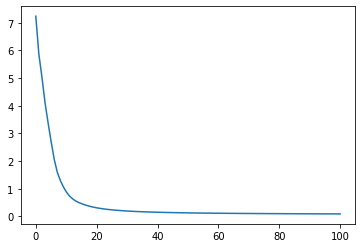

In [15]:
 print(len(train_losses))
iter = np.linspace(0,len(train_losses),len(train_losses))
plt.plot(iter,train_losses)
plt.show()


**Training the regression, skip these blocks for now**

In [16]:
pretrained_dict = perPix_model.state_dict()
modelR = DRNSeg(2)    
model_dict=modelR.state_dict()
# filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                       (k in model_dict) and (model_dict[k].shape == pretrained_dict[k].shape)}

model_dict.update(pretrained_dict) 
modelR.load_state_dict(model_dict)

device = torch.device(cuda0)
modelR.to(device)







#the function below is very messy atm, im just happy that it works, it needs to be cleaned up though
#it just converts and reshapes tensors to numpy arrays and vica versa during training for the recreational loss

#creates the recreation loss, unwarps image and compares with the original image

b_size=1
my_dataset_reg = TensorDataset(train_x,train_y) # create your datset
my_dataloader_reg = DataLoader(my_dataset_reg,batch_size=b_size)

loss = nn.MSELoss()
def train_regress(epoch):
    for idx,(x_t,y_t) in enumerate(my_dataloader_reg):
      modelR.train()
      tr_loss = 0
      # getting the training set
      x_train, y_train = Variable(x_t), Variable(y_t)
      x_train_orig=Variable(torch.from_numpy(train_x_orig))
      # converting the data into GPU format
      if torch.cuda.is_available():
          x_train = x_train.cuda()
          y_train = y_train.cuda()
          x_train_orig=x_train_orig.cuda()  
     
      optimizer.zero_grad()

      output_train = modelR(x_train.float()).float()
  
      total = train_size
     
 
      MS_loss_train =loss(output_train, y_train.float())
      
      loss_train=MS_loss_train 
      train_losses.append(loss_train)
      
      # computing the updated weights of all the model parameters
      loss_train.backward()
      optimizer.step()
      tr_loss = loss_train.item()

      if epoch%10 == 0:
          # printing the validation loss
          print('Epoch : ',epoch+1, "for Batch:",idx, '\t', 'loss :',tr_loss)
          
          print("\n")

In [17]:
n_epochs = 150
train_losses =[]
correct =0
#same parameters the FAL paper have used
optimizer = Adam(modelR.parameters(),lr=0.001,betas =(0.9,0.999)) 
for epoch in range(n_epochs): 
    train_regress(epoch)

Epoch :  1 for Batch: 0 	 loss : 370.6483459472656


Epoch :  1 for Batch: 1 	 loss : 5265.23193359375


Epoch :  1 for Batch: 2 	 loss : 1590.966552734375


Epoch :  11 for Batch: 0 	 loss : 12.694202423095703


Epoch :  11 for Batch: 1 	 loss : 5.738725662231445


Epoch :  11 for Batch: 2 	 loss : 45.60393524169922


Epoch :  21 for Batch: 0 	 loss : 6.59570837020874


Epoch :  21 for Batch: 1 	 loss : 1.2226217985153198


Epoch :  21 for Batch: 2 	 loss : 35.40241622924805


Epoch :  31 for Batch: 0 	 loss : 5.852321147918701


Epoch :  31 for Batch: 1 	 loss : 0.9822360873222351


Epoch :  31 for Batch: 2 	 loss : 30.451305389404297


Epoch :  41 for Batch: 0 	 loss : 5.022485256195068


Epoch :  41 for Batch: 1 	 loss : 1.081168293952942


Epoch :  41 for Batch: 2 	 loss : 29.13383674621582


Epoch :  51 for Batch: 0 	 loss : 3.177865505218506


Epoch :  51 for Batch: 1 	 loss : 0.5638669729232788


Epoch :  51 for Batch: 2 	 loss : 19.841066360473633


Epoch :  61 for Batch: 0 	 

In [ ]:
from FALdetector.utils.visualize import *




In [18]:
#function to
def get_heatmap_cv(img, magn, max_flow_mag):
    min_flow_mag = 5
    cv_magn = np.clip(
        255 * (magn - min_flow_mag) / (max_flow_mag - min_flow_mag),
        a_min=0,
        a_max=255).astype(np.uint8)
    if img.dtype != np.uint8:
        img = (255 * img).astype(np.uint8)
        
    heatmap_img = cv2.applyColorMap(cv_magn, cv2.COLORMAP_MAGMA)
    heatmap_img = heatmap_img[..., ::-1]
    h, w = magn.shape
    img_alpha = np.ones((h, w), dtype=np.double)[:, :, None]
    heatmap_alpha = np.clip(
        magn / max_flow_mag, a_min=0, a_max=1)[:, :, None]**.7
    heatmap_alpha[heatmap_alpha < .2]**.5
    pm_hm = heatmap_img * heatmap_alpha
    pm_img = img * img_alpha
    cv_out = pm_hm + pm_img * (1 - heatmap_alpha)
    cv_out = np.clip(cv_out, a_min=0, a_max=255).astype(np.uint8)
    return cv_out

def save_heatmap_cv(img, magn, path, max_flow_mag=2):
    cv_out = get_heatmap_cv(img, magn, max_flow_mag)
    out = Image.fromarray(cv_out)
    plt.imshow(out)
    plt.show()
    out.save(path, quality=95)
    return out

In [19]:
from utils.tools import *
from utils.visualize import *




In [20]:
#quick sanity check again

#print(flow.shape)
#print(pic.size)

**uses training image to predict the flow field**

(400, 400, 3)


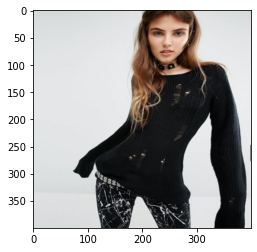

(1, 400, 400, 3)
(1, 3, 400, 400)
perpixel original shape (1, 400, 400)
(2, 400, 400)
[[[-0.40531313 -0.49538273 -0.5854523  ... -0.4663752  -0.39462516
   -0.32287514]
  [-0.49538273 -0.60546774 -0.7155528  ... -0.5700141  -0.48231965
   -0.39462516]
  [-0.5854523  -0.7155528  -0.8456533  ... -0.67365307 -0.5700141
   -0.4663752 ]
  ...
  [-0.26875952 -0.32848385 -0.38820818 ... -0.6633956  -0.5613347
   -0.45927384]
  [-0.2274119  -0.27794787 -0.32848385 ... -0.5613347  -0.47497553
   -0.38861632]
  [-0.18606429 -0.2274119  -0.26875952 ... -0.45927384 -0.38861632
   -0.31795883]]

 [[ 0.39413735  0.48172343  0.5693095  ...  0.16498293  0.13960093
    0.11421895]
  [ 0.48172343  0.5887731   0.6958227  ...  0.2016458   0.17062338
    0.13960093]
  [ 0.5693095   0.6958227   0.82233596 ...  0.23830867  0.2016458
    0.16498293]
  ...
  [ 0.3818093   0.4666558   0.5515023  ...  0.7546528   0.63855237
    0.52245194]
  [ 0.3230694   0.3948626   0.4666558  ...  0.63855237  0.54031354
    0.

In [25]:
test_ref = X_ref[1]
test_mod = X_mod[1]




print(test_mod.shape)
def load_data(img_path, device):
    face = Image.open(img_path).convert('RGB')
    face = face.resize((400,400))
    face_tens = tf(face).to(device)
    return face_tens, face
pathM ="/content/modif/ref_001.jpg"
pathR ="/content/ref/ref_001.jpg"
imgR, modified = load_data(r""+pathM, device)
imgR_ref, reference = load_data(r""+pathR, device)
test_ref= np.array(Image.open(r""+pathR).resize( (width, height)))
test_mod= np.array(Image.open(r""+pathM).resize( (width, height)))
plt.imshow(test_mod)
plt.show()


ground_flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(test_ref,cv2.COLOR_BGR2GRAY), cv2.cvtColor(test_mod,cv2.COLOR_BGR2GRAY),None, 0.5, 3, 4, 2, 3, 1.2, 0)
image = np.array([test_mod])

shapes = image.shape
print(shapes)
image = np.transpose(image,(0,3,1,2))
print(image.shape)
image_tensor = torch.from_numpy(image)
image_tensor= Variable(image_tensor)
# converting the data into GPU format
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()


#ground_flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(test_ref,cv2.COLOR_BGR2GRAY), cv2.cvtColor(test_mod,cv2.COLOR_BGR2GRAY),None, 0.5, 3, 4, 2, 3, 1.2, 0)

with torch.no_grad():
        flow = perPix_model(image_tensor.float()).cpu().numpy()
        
        flow = np.argmax(flow,1)
        print("perpixel original shape",flow.shape)
        flow =flow[0]
        #print(flow.shape)
        #print(flow)
        real_flow = np.zeros((2,400,400))
        temp =0
        for i in range(shapes[1]):
          for j in range(shapes[2]):
            real_flow[:,i,j]=inv_dic[int(flow[i][j])]
        #print(real_flow.shape)
        np.set_printoptions(edgeitems=3)
        #print(real_flow)
        real_flow = np.transpose(real_flow, (1, 2, 0))
      
        flow_reg = modelR(imgR.unsqueeze(0))[0].cpu().numpy()
        print(flow_reg.shape)
        print(flow_reg)
        flow_reg = np.transpose(flow_reg, (1, 2, 0))
        print(flow_reg.shape)
        w, h, _ = real_flow.shape

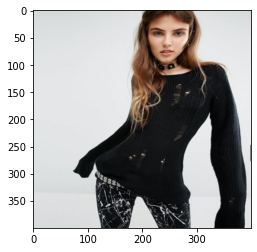

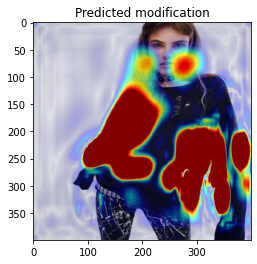

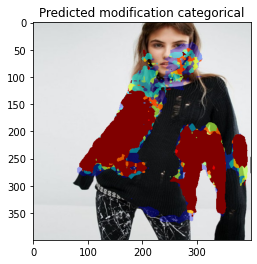

In [26]:

flow = flow_resize(flow_reg, modified.size)
flow_categ = flow_resize(real_flow, modified.size)
plt.imshow(modified)
modified_np = np.array(modified)
plt.show()
mag, ang = cv2.cartToPolar(flow[:,:,1], flow[:,:,0])
mag_c, ang = cv2.cartToPolar(flow_categ[:,:,0], flow_categ[:,:,1])
path = "tester.png"
tester =get_heatmap_cv(modified_np,mag,max_flow_mag=5)
plt.title("Predicted modification")
plt.imshow(tester)
plt.show()
tester2 =get_heatmap_cv(modified_np,mag_c,max_flow_mag=5)
plt.title("Predicted modification categorical")
plt.imshow(tester2)



**plots the ground truth heatmap on the image**

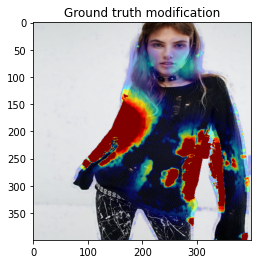

In [27]:

mag, ang = cv2.cartToPolar(ground_flow[...,0], ground_flow[...,1])
#print(mag.shape)

real = get_heatmap_cv(np.array(reference),mag,max_flow_mag=12)
plt.title("Ground truth modification")
plt.imshow(real)

In [ ]:
model_path = r"model.pt"
torch.save(model.state_dict(), model_path)